In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.text_processing.transformations.synonyms import toy_transformation
from lr.stats.h_testing import DGP, get_matched_results, get_paired_t_statistic
from lr.stats.h_testing import get_boot_sample_under_H0,get_boot_p_value
from lr.stats.h_testing import  LIMts_test
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(train)
pre_process_nli_df(dev)

### Training a model using one version of the modified data

In [3]:
max_features = 500
rho = 0.001
label_translation = get_ternary_label
transformation = entailment_internalization 

dgp = DGP(data=train, transformation=transformation, rho=rho)
train_t = dgp.get_sample()

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1.0,
               'solver': 'lbfgs'}
lr = LRWrapper(hyperparams)
lr.fit(train_t)

### Get t statistic for the observable results and matched results

In [4]:
dev_t = transformation(dev)

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-1.2964074471043285


### Get $S$ bootstrap replications under H0

In [5]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

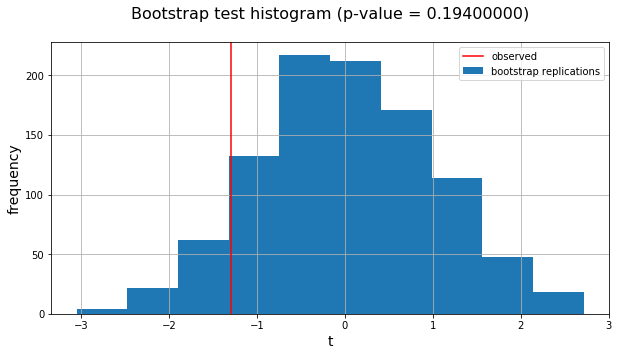

In [6]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

### Performing multiple tests

**test1: entailment internalization**

In [7]:
M,E,S = 5,2,1000


tests1 = LIMts_test(train=train,
                    dev=dev,
                    train_transformation=entailment_internalization,
                    dev_transformation=entailment_internalization,
                    rho=0.78,
                    Model=LRWrapper,
                    hyperparams=hyperparams,
                    M=M,
                    E=E,
                    S=S)

tests1

,m,train_accuracy_mean,train_accuracy_std,train_accuracy_ensemble,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,0.7650,0.0,0.7650,0.305,0.545,-7.947194,0.0,0.012666,0.150603,...,0.324528,0.437805,-0.982559,0.000000,-1.046351,-0.288735,-1.002509,0.000000,2.246624,-1.210455
1,2,0.7475,0.0,0.7475,0.315,0.565,-8.164966,0.0,0.013650,0.128646,...,0.308680,-0.674967,-0.134846,-1.581221,-1.210455,1.018633,-0.687614,-1.135009,-0.156183,0.420269
2,3,0.7475,0.0,0.7475,0.310,0.535,-7.620008,0.0,0.011135,0.142053,...,-1.614943,0.950825,0.145873,1.775233,-0.950825,-0.412257,1.727737,-0.164410,0.833494,1.187379
3,4,0.7400,0.0,0.7400,0.310,0.550,-7.947194,0.0,0.008762,0.138391,...,-0.674967,-0.140035,-0.420269,-1.339299,-0.850060,1.318761,-0.447437,-0.763604,0.000000,-0.817861
4,5,0.7500,0.0,0.7500,0.315,0.565,-8.164966,0.0,0.006273,0.130111,...,0.867654,-0.132459,-0.869884,0.000000,0.137367,0.590281,-0.145873,-2.575905,0.701000,-0.267309


### Diferent bootstrap distributions for each experiment

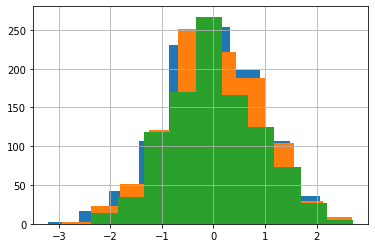

In [8]:
column_cropper(tests1,"boot").iloc[0].hist()
column_cropper(tests1,"boot").iloc[1].hist()
column_cropper(tests1,"boot").iloc[2].hist()

**test2: toy transformation**

In [9]:
tests2 = LIMts_test(train=train,
                   dev=dev,
                   train_transformation=toy_transformation,
                   dev_transformation=toy_transformation,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=M,
                   E=1,
                   S=S)

tests2

,m,train_accuracy_mean,train_accuracy_std,train_accuracy_ensemble,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,0.64875,0.0,0.64875,0.220,0.205,0.906390,0.360,0.007467,0.079197,...,0.728572,-0.577832,0.000000,0.000000,1.002509,0.000000,0.817861,-0.633089,-0.707992,0.707992
1,2,0.64375,0.0,0.64375,0.205,0.230,-1.678363,0.082,0.004862,0.079196,...,0.447437,2.134484,0.633089,-0.333426,1.002509,-0.707992,-0.333426,-0.378100,-0.301580,-0.817861
2,3,0.64750,0.0,0.64750,0.220,0.225,-0.378100,0.764,0.004286,0.051267,...,-0.447437,0.000000,1.002509,2.145596,-0.906390,1.002509,0.000000,1.347719,0.000000,0.000000
3,4,0.64875,0.0,0.64875,0.215,0.225,-1.002509,0.332,0.005410,0.052447,...,0.000000,0.817861,-1.421338,0.447437,0.378100,0.447437,2.264554,-1.745189,-1.643990,1.745189
4,5,0.65250,0.0,0.65250,0.215,0.225,-1.002509,0.358,0.005289,0.059158,...,1.643990,-1.643990,-2.487080,-0.577832,0.000000,NaN,0.577832,0.000000,1.906925,0.817861


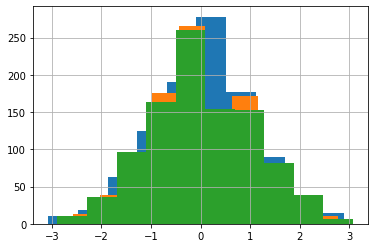

In [10]:
column_cropper(tests2,"boot").iloc[0].hist()
column_cropper(tests2,"boot").iloc[1].hist()
column_cropper(tests2,"boot").iloc[2].hist()

In [11]:
assert np.any(tests1.p_value < (0.05/M))
assert not np.any(tests2.p_value < (0.05/M))